C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 Episode: Finished after 12 steps
1 Episode: Finished after 10 steps
2 Episode: Finished after 8 steps
3 Episode: Finished after 9 steps
4 Episode: Finished after 10 steps
5 Episode: Finished after 11 steps
6 Episode: Finished after 8 steps
7 Episode: Finished after 10 steps
8 Episode: Finished after 10 steps
9 Episode: Finished after 9 steps
10 Episode: Finished after 8 steps
11 Episode: Finished after 11 steps
12 Episode: Finished after 11 steps
13 Episode: Finished after 11 steps
14 Episode: Finished after 10 steps
15 Episode: Finished after 9 steps
16 Episode: Finished after 12 steps
17 Episode: Finished after 9 steps
18 Episode: Finished after 11 steps
19 Episode: Finished after 12 steps
20 Episode: Finished after 10 steps
21 Episode: Finished after 11 steps
22 Episode: Finished after 9 steps
23 Episode: Finished after 9 steps
24 Episode: Finished after 10 steps
25 Episode: Finished after 12 steps
26 Episode: Finished after 14 steps
27 Episode: Finished after 19 steps
28 Episode:

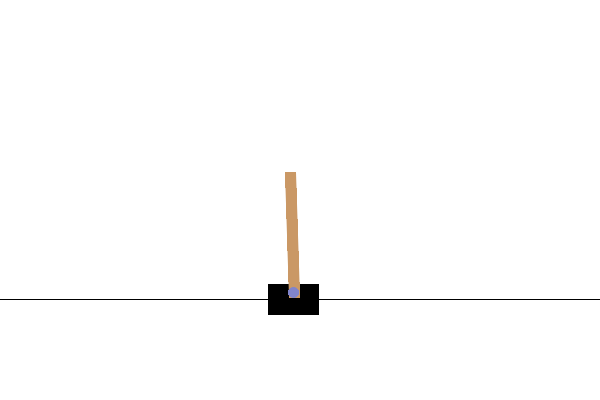

In [1]:

# pip install gym matplotlib torch imageio

import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple
import random
import imageio
from IPython.display import Image, display

# --- 設定定数 ---
ENV = 'CartPole-v1'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500
BATCH_SIZE = 32
CAPACITY = 10000

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# --- GIF 保存＆表示関数 ---
def save_gif(frames, filename="cartpole.gif"):
    imageio.mimsave(filename, frames, fps=30)
    display(Image(filename=filename))

# --- Replay Memory ---
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.index] = Transition(*args)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- ニューラルネットワーク ---
class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- Brain（Qネットワーク + Replay） ---
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.memory = ReplayMemory(CAPACITY)
        self.main_q = Net(num_states, 32, num_actions)
        self.target_q = Net(num_states, 32, num_actions)
        self.optimizer = optim.Adam(self.main_q.parameters(), lr=0.0001)

    def decide_action(self, state, episode):
        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.rand():
            self.main_q.eval()
            with torch.no_grad():
                return self.main_q(state).max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(self.num_actions)]])

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = Transition(*zip(*self.memory.sample(BATCH_SIZE)))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        non_final_mask = torch.tensor([s is not None for s in batch.next_state], dtype=torch.bool)
        state_action_values = self.main_q(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(BATCH_SIZE)
        a_m = torch.zeros(BATCH_SIZE, dtype=torch.long)
        a_m[non_final_mask] = self.main_q(non_final_next_states).detach().max(1)[1]
        a_m_non_final = a_m[non_final_mask].view(-1, 1)
        next_state_values[non_final_mask] = self.target_q(non_final_next_states).gather(1, a_m_non_final).detach().squeeze()
        expected = reward_batch + GAMMA * next_state_values
        loss = F.smooth_l1_loss(state_action_values, expected.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        self.target_q.load_state_dict(self.main_q.state_dict())

# --- Agent ---
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)

    def get_action(self, state, episode):
        return self.brain.decide_action(state, episode)

    def memorize(self, *args):
        self.brain.memory.push(*args)

    def update_q_function(self):
        self.brain.replay()

    def update_target_q_function(self):
        self.brain.update_target_q_network()

# --- 環境 ---
class Environment:
    def __init__(self):
        self.env = gym.make(ENV, render_mode="rgb_array")
        self.agent = Agent(self.env.observation_space.shape[0], self.env.action_space.n)

    def run(self):
        episode_10_list = np.zeros(10)
        frames = []
        record_next = False

        for episode in range(NUM_EPISODES):
            observation, _ = self.env.reset()
            state = torch.FloatTensor(observation).unsqueeze(0)

            for step in range(MAX_STEPS):
                if record_next:
                    frames.append(self.env.render())

                action = self.agent.get_action(state, episode)
                observation_next, reward, terminated, truncated, _ = self.env.step(action.item())
                done = terminated or truncated

                if done:
                    state_next = None
                    reward = torch.FloatTensor([1.0 if step + 1 >= 200 else -1.0])
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = torch.FloatTensor(observation_next).unsqueeze(0)

                self.agent.memorize(state, action, state_next, reward)
                self.agent.update_q_function()
                state = state_next

                if done:
                    print(f"{episode} Episode: Finished after {step + 1} steps")
                    if step + 1 >= 200:
                        print("🎉 200ステップ成功：次エピソードで録画開始")
                        record_next = True
                    if episode % 2 == 0:
                        self.agent.update_target_q_function()
                    break

            if record_next:
                # 録画専用エピソード
                observation, _ = self.env.reset()
                state = torch.FloatTensor(observation).unsqueeze(0)
                for _ in range(MAX_STEPS):
                    frames.append(self.env.render())
                    action = self.agent.get_action(state, episode)
                    observation_next, reward, terminated, truncated, _ = self.env.step(action.item())
                    done = terminated or truncated
                    if done:
                        break
                    state = torch.FloatTensor(observation_next).unsqueeze(0)
                break  # 録画後終了

        if frames:
            save_gif(frames, "cartpole.gif")

# --- 実行 ---
env = Environment()
env.run()

